# Part 2: Country recommender using World Bank data in Python
Janos Perge

###Approach:

For each country, calculate a Country Preference Score, i.e. a weighted average of selected indicators.
  
This means:  
1) select country indicators   
2) normalize indicators   
3) assign importance scores for each indicator  
4) calculate score*  
5) deliver the top 30 countries with the highest score

*Country Preference Score = (indicator1 x score1 + indicator2 x score2 .... indicatorEnd x scoreEnd)/ number of indicators

As indicator values were occasionally missing in certain years, I calculated the average value over the past five years.


## Import Python libraries

In [1]:
%matplotlib inline

import wbdata
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py

## Select relevant indicators

I explored indicators using methods such as:
wbdata.get_source(), 
wbdata.get_indicator(source=2), or 
wbdata.search_indicators("gdp per capita, ppp")

Here are the results:

In [2]:
# INPUT PARAMETERS

indicators     = {'SP.DYN.LE00.IN': 'Life expectancy',
                  'SH.DTH.COMM.ZS': 'dye from disease',
                  'SH.DTH.INJR.ZS': 'dye from injury',                
                  'SP.DYN.CDRT.IN': 'crude death rate/1000pers',                  
                  'EN.ATM.CO2E.PC': 'CO2 emission/capita',
                  'NY.GDP.PCAP.PP.CD': 'GDP',
                  'SL.UEM.TERT.ZS': 'unemployment tertiary',
                  'SL.UEM.SECO.ZS': 'unemployment secondary',
                  'SL.EMP.TOTL.SP.NE.ZS': 'employed ratio (+15yo)'}

subjPreference = {'Life expectancy': 1,
                  'dye from disease': -1,
                  'dye from injury': -1,
                  'crude death rate/1000pers':-.6,
                  'CO2 emission/capita': -.4,

                  'GDP': .9,
                  'unemployment tertiary': -.9,
                  'unemployment secondary': -.5,
                  'employed ratio (+15yo)': -.3}

yearLow        = 2010
yearHigh       = 2015


## Obtain country codes and names

In [3]:
#obtain country codes and regional metadata:
countryInfo = wbdata.get_country(country_id=None, display=False)
dfInfo = pd.DataFrame(countryInfo)

#remove aggregate countries:
ccodes = [];
cnames = [];
for i in range(len(dfInfo)):
    if str(dfInfo['region'][i]['value'])  != 'Aggregates':
        ccodes.append(dfInfo['id'][i])
        cnames.append(dfInfo['name'][i])
dfM = pd.DataFrame(ccodes, index=cnames, columns=['id'])
dfM.index.name = 'country'
dfM.head()

,id
country,
Aruba,ABW
Afghanistan,AFG
Angola,AGO
Albania,ALB
Andorra,AND


In [4]:
# GIVEN THE LIST OF COUNTRY CODES, YEARS AND INDICATORS, ADD DATA COLUMNS TO dfM:
#indicator format = {indicatorCode:indicatorLabel} 
data_date = (datetime.datetime(yearLow, 1, 1), datetime.datetime(yearHigh, 12, 1)) 

for measure, label in indicators.items():
    df = wbdata.get_dataframe({measure: label}, country = ccodes, data_date=data_date, convert_date=False, keep_levels=False)
    # average across the last five years of data (to also deal with missing values):
    ind = df.groupby(level=0).mean()        
    dfM[label] = ind

dfM.head()

,id,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy
country,,,,,,,,,,
Aruba,ABW,24.052557,36015.070460,NaN,8.13175,NaN,NaN,NaN,NaN,75.142835
Afghanistan,AFG,0.364099,1831.702129,NaN,8.24975,NaN,17.4,46.0,NaN,60.276500
Angola,AGO,1.377831,6790.368992,NaN,14.38325,NaN,9.5,66.4,NaN,51.260915
Albania,ALB,1.561335,9791.736557,NaN,6.75575,NaN,5.5,5.1,49.975,77.257360
Andorra,AND,6.046728,NaN,NaN,3.35000,NaN,NaN,NaN,NaN,NaN


In [9]:
# NORMALIZE DATA TO BRING DIFFERENT INDICATORS INTO THE SAME SCALE
df = dfM
for label in indicators.values():
    df[label] = (df[label] - df[label].min())
    df[label] = df[label]/df[label].max()
df.head()

,id,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy,Preference Score
country,,,,,,,,,,,
Aruba,ABW,0.445101,0.261039,NaN,0.570596,NaN,NaN,NaN,NaN,0.783238,0.538571
Afghanistan,AFG,0.992076,0.008658,NaN,0.563433,NaN,0.683036,0.377095,NaN,0.394298,-0.802888
Angola,AGO,0.968669,0.045269,NaN,0.191119,NaN,0.859375,0.092179,NaN,0.158428,-1.347137
Albania,ALB,0.964432,0.067428,NaN,0.654122,NaN,0.948661,0.948324,0.599095,0.838559,0.454204
Andorra,AND,0.860862,NaN,NaN,0.860857,NaN,NaN,NaN,NaN,NaN,-0.139141


In [22]:
#APPLY SUBJECTIVE PREFERENCE SCORE FOR EACH INDICATOR AND REARRANGE COLUMNS FOR BETTER VISIBILITY
for label, score in subjPreference.items():    
    df[label] = df[label]*score    

df['Preference Score']= df.sum(axis = 1)
cols = df.columns.tolist()
cols.insert(1, cols.pop(cols.index('Preference Score')))
df = df.reindex(columns= cols)
df.head()

,id,Preference Score,CO2 emission/capita,GDP,unemployment secondary,crude death rate/1000pers,unemployment tertiary,dye from injury,dye from disease,employed ratio (+15yo),Life expectancy
country,,,,,,,,,,,
Aruba,ABW,1.036346,-0.178040,0.234935,NaN,-0.342358,NaN,NaN,NaN,NaN,0.783238
Afghanistan,AFG,-2.195819,-0.396831,0.007792,NaN,-0.338060,NaN,-0.683036,-0.377095,NaN,0.394298
Angola,AGO,-2.601661,-0.387468,0.040742,NaN,-0.114672,NaN,-0.859375,-0.092179,NaN,0.158428
Albania,ALB,-1.501510,-0.385773,0.060685,NaN,-0.392473,NaN,-0.948661,-0.948324,-0.179729,0.838559
Andorra,AND,-1.000000,-0.344345,NaN,NaN,-0.516514,NaN,NaN,NaN,NaN,NaN


In [23]:
#DISCARD COUNTRIES WITH MULTIPLE MISSING DATA (allow max 3 missing indicators)
totalCols = len(df.columns)
minRequiredIndicator = totalCols - 4
ii = df.count(axis=1) > minRequiredIndicator
dff = df.loc[ii, :]
dff.head()

# calculate average:
N = dff.count(axis=1)-2
dff.loc[:,'Preference Score'] /= N
    
dff['Preference Score'].head()

country
Afghanistan            -0.365970
Angola                 -0.433610
Albania                -0.214501
United Arab Emirates   -0.091347
Argentina              -0.386571
Name: Preference Score, dtype: float64

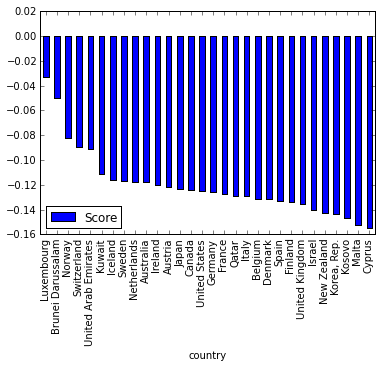

In [24]:
#PLOT RESULTS
dataToPlot = pd.DataFrame(list(dff['Preference Score']), index = dff.index, columns = ['Score'])
dataToPlot = dataToPlot.sort_values('Score', ascending=False)

dataToPlot.iloc[:30].plot(kind='bar')


In [25]:
#PLOT IN BROWSER

import plotly.graph_objs as go
import plotly.plotly as py

firstX = 30
dataToPlot = dataToPlot.iloc[:firstX][:firstX]

data = [
    go.Bar(
        x = list(dataToPlot['Score']),
        y = list(dataToPlot.index),
        orientation = 'h',
    )
]
plot_url = py.plot(data, filename='country-recommender-horizontal-bar')

In [28]:
#Highest scoring countries on the Human Development Index, as of 2014 (Source Wikipedia):
HDIWinners = ['Norway', 'Australia', 'Switzerland', 'Netherlands', 
              'United States', 'Germany', 'New Zealand', 'Canada', 
              'Singapore', 'Denmark','Ireland', 'Sweden', 'Iceland', 
              'United Kingdom', 'Hong Kong', 'South Korea', 'Japan', 
              'Lichtenstein', 'Israel', 'France', 'Austria', 'Belgium',
              'Luxembourg', 'Finland', 'Slovenia', 'Italy', 'Spain', 
              'Czech Republic', 'Greece', 'Brunei Darussalam']



In [37]:
intersect = [val for val in HDIWinners if val in list(dataToPlot.index)]
percentMatch = 100*len(intersect)/30
print '%i percent of the recommended countries were also within the best thirty by the Human Development index' % (percentMatch)


73 percent of the recommended countries were also within the best thirty by the Human Development index
